This notebooks explores the performance of ETFs to see which would be the most useful to invest

In [98]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.optimize import minimize, LinearConstraint

In [1]:
ETF_DATA_FILEPATH = "../data/raw/ETF_data.pkl"
ETF_METADATA_FILEPATH = "../data/raw/ETF_metadata.csv"
NUM_DAYS_TIME_HORIZON = 365
BENCHMARK_SYMBOL = "SPY"  # use the S&P 500 ETF to normalize
ANALYSIS_COLUMN = "Adj Close"  # includes more info representative of the value. Not exactly the price.

In [100]:
etf_data = pd.read_pickle(ETF_DATA_FILEPATH)
etf_data

IEMG                                                        \
                 Open       High        Low      Close  Adj Close    Volume   
Date                                                                          
2016-05-16  39.880001  40.080002  39.820000  39.950001  35.155415   2914200   
2016-05-17  39.919998  40.080002  39.689999  39.790001  35.014618   7790600   
2016-05-18  40.650002  40.650002  39.250000  39.480000  34.741825  36141400   
2016-05-19  39.169998  39.220001  38.900002  39.160000  34.460228  13545700   
2016-05-20  39.509998  39.599998  39.419998  39.520000  34.777020   9181400   
...               ...        ...        ...        ...        ...       ...   
2021-05-10  66.099998  66.139999  65.190002  65.220001  65.220001  11628300   
2021-05-11  64.019997  65.059998  64.019997  64.989998  64.989998   7587200   
2021-05-12  63.880001  64.150002  63.099998  63.189999  63.189999  11371800   
2021-05-13  63.380001  63.709999  62.810001  63.169998  63.169998  10868900   
2021-05-14  63.840000  64.309998  63.680000  64.199997  64.199997   9890800   

                  VWO                                   ...      SOXS  \
                 Open       High        Low      Close  ...       Low   
Date                                                    ...             
2016-05-16  33.150002  33.369999  33.139999  33.240002  ...  21960.00   
2016-05-17  33.220001  33.310001  32.980000  33.099998  ...  22146.00   
2016-05-18  32.919998  33.279999  32.650002  32.840000  ...  21216.00   
2016-05-19  32.470001  32.549999  32.250000  32.439999  ...  21588.00   
2016-05-20  32.730000  32.919998  32.700001  32.799999  ...  20058.00   
...               ...        ...        ...        ...  ...       ...   
2021-05-10  53.130001  53.209999  52.470001  52.500000  ...      9.66   
2021-05-11  51.549999  52.410000  51.520000  52.360001  ...     10.56   
2021-05-12  51.560001  51.779999  50.939999  51.020000  ...     11.14   
2021-05-13  51.169998  51.450001  50.689999  50.959999  ...     10.92   
2021-05-14  51.470001  51.869999  51.349998  51.799999  ...     10.10   

                                                     TLT              \
               Close     Adj Close    Volume        Open        High   
Date                                                                   
2016-05-16  22452.00  21947.707031       347  131.639999  131.660004   
2016-05-17  22908.00  22393.464844       136  131.210007  131.830002   
2016-05-18  21780.00  21290.800781       615  130.809998  130.850006   
2016-05-19  22176.00  21677.906250       624  129.679993  130.330002   
2016-05-20  20118.00  19666.130859       699  129.649994  130.399994   
...              ...           ...       ...         ...         ...   
2021-05-10     10.76     10.760000   8259600  138.949997  139.250000   
2021-05-11     10.65     10.650000  16115300  137.229996  137.479996   
2021-05-12     12.01     12.010000  18053600  136.669998  136.800003   
2021-05-13     11.42     11.420000  13719500  135.929993  136.369995   
2021-05-14     10.42     10.420000  10687800  136.529999  137.080002   

                                                          
                   Low       Close   Adj Close    Volume  
Date                                                      
2016-05-16  130.979996  131.139999  117.377434   5137000  
2016-05-17  131.210007  131.360001  117.574371   4449100  
2016-05-18  128.910004  129.490005  115.900620  12681000  
2016-05-19  129.649994  130.050003  116.401855   6209400  
2016-05-20  129.550003  130.149994  116.491341   5348900  
...                ...         ...         ...       ...  
2021-05-10  137.690002  137.820007  137.820007  15146200  
2021-05-11  136.770004  137.039993  137.039993  15158600  
2021-05-12  135.360001  135.600006  135.600006  20859400  
2021-05-13  135.630005  135.809998  135.809998  13073900  
2021-05-14  136.220001  137.080002  137.080002  17566300  

[1259 rows x 600 columns]

In [101]:
end_date = datetime.now()
time_horizon = timedelta(days=NUM_DAYS_TIME_HORIZON)
start_date = end_date - time_horizon

In [102]:
filtered_etf_data = etf_data[start_date <= etf_data.index]
daily_prices = pd.DataFrame()
for symbol, subcolumn in filtered_etf_data:
    if subcolumn == ANALYSIS_COLUMN:
        daily_prices[symbol] = filtered_etf_data[symbol][subcolumn]
        
daily_prices

,IEMG,VWO,SLV,VEA,VIXY,SRTY,PSQ,SQQQ,MCHI,PDBC,...,IJR,VTI,JETS,ERX,SH,JDST,KRE,XLRE,SOXS,TLT
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-18,43.678253,36.327740,15.790000,35.395924,28.139999,76.199997,20.860001,51.000000,61.992985,12.119207,...,61.988052,146.238983,13.384604,15.863337,23.719999,21.459999,34.158089,31.326300,97.440002,160.773407
2020-05-19,43.335564,35.965542,16.170000,35.015114,29.559999,80.650002,20.910000,51.450001,61.775463,12.069210,...,60.724606,144.684082,13.204676,14.989591,23.969999,19.299999,32.675060,30.718868,98.760002,161.374939
2020-05-20,43.893658,36.415844,16.360001,35.649796,27.770000,73.400002,20.500000,48.299999,62.180840,12.259198,...,62.619778,147.360855,13.684482,16.135172,23.549999,19.500000,34.342258,31.008120,87.720001,161.858078
2020-05-21,43.492222,36.043854,15.960000,35.259216,28.379999,72.849998,20.730000,49.799999,60.658203,12.179204,...,62.679005,146.475143,13.914390,15.649756,23.730000,20.570000,34.216248,30.853853,94.440002,162.262344
2020-05-22,42.620811,35.358604,16.040001,35.161572,28.160000,71.900002,20.639999,49.349998,58.413803,12.119207,...,62.935642,146.888474,13.694478,15.455588,23.670000,20.660000,33.857609,31.528780,92.760002,163.238510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-10,65.220001,52.500000,25.350000,51.869999,7.830000,10.630000,13.590000,12.080000,78.349998,19.370001,...,110.489998,216.179993,25.930000,28.010000,15.870000,9.200000,70.029999,42.560001,10.760000,137.820007
2021-05-11,64.989998,52.360001,25.670000,51.250000,8.440000,10.730000,13.580000,12.120000,78.949997,19.590000,...,109.760002,214.440002,25.530001,26.580000,16.000000,8.950000,69.430000,42.060001,10.650000,137.039993
2021-05-12,63.189999,51.020000,25.090000,50.349998,9.890000,11.770000,13.940000,13.060000,78.000000,19.549999,...,106.379997,209.610001,24.780001,26.830000,16.360001,9.410000,67.699997,41.040001,12.010000,135.600006


In [103]:
normalized_prices  = (daily_prices-daily_prices.iloc[0]).div(daily_prices[BENCHMARK_SYMBOL], axis=0)
normalized_prices

,IEMG,VWO,SLV,VEA,VIXY,SRTY,PSQ,SQQQ,MCHI,PDBC,...,IJR,VTI,JETS,ERX,SH,JDST,KRE,XLRE,SOXS,TLT
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-05-19,-0.001193,-0.001260,0.001322,-0.001325,0.004942,0.015486,0.000174,0.001566,-0.000757,-0.000174,...,-0.004397,-0.005411,-0.000626,-0.003041,0.000870,-0.007517,-0.005161,-0.002114,0.004594,0.002093
2020-05-20,0.000737,0.000301,0.001950,0.000869,-0.001266,-0.009581,-0.001232,-0.009239,0.000643,0.000479,...,0.002162,0.003839,0.001026,0.000930,-0.000582,-0.006707,0.000630,-0.001089,-0.033260,0.003712
2020-05-21,-0.000641,-0.000978,0.000586,-0.000471,0.000827,-0.011543,-0.000448,-0.004135,-0.004599,0.000207,...,0.002381,0.000814,0.001825,-0.000736,0.000034,-0.003067,0.000200,-0.001628,-0.010337,0.005130
2020-05-22,-0.003637,-0.003333,0.000860,-0.000806,0.000069,-0.014788,-0.000757,-0.005674,-0.012309,0.000000,...,0.003259,0.002234,0.001066,-0.001402,-0.000172,-0.002751,-0.001033,0.000696,-0.016095,0.008478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-10,0.051543,0.038695,0.022874,0.039417,-0.048595,-0.156889,-0.017395,-0.093123,0.039137,0.017349,...,0.116050,0.167347,0.030017,0.029063,-0.018783,-0.029334,0.085830,0.026879,-0.207398,-0.054920
2021-05-11,0.051452,0.038706,0.023853,0.038275,-0.047560,-0.158060,-0.017576,-0.093865,0.040938,0.018036,...,0.115333,0.164653,0.029322,0.025873,-0.018638,-0.030202,0.085155,0.025914,-0.209531,-0.057298
2021-05-12,0.048128,0.036240,0.022940,0.036886,-0.045016,-0.158926,-0.017069,-0.093584,0.039484,0.018329,...,0.109499,0.156313,0.028108,0.027051,-0.018154,-0.029723,0.082736,0.023960,-0.210725,-0.062094


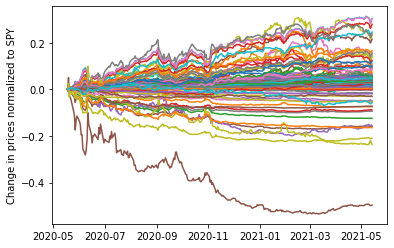

In [104]:
# plot the growth of all etfs
plt.plot(normalized_prices)
plt.ylabel(f"Change in prices normalized to {BENCHMARK_SYMBOL}")
None

Text(0, 0.5, 'Change in prices normalized to SPY')

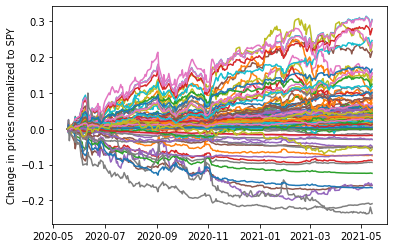

In [105]:
# Filter out outliers
filtered_normalized_prices = normalized_prices.loc[:, normalized_prices.loc["2021-05-14", :] >= -0.3]
# plot the growth of all etfs
plt.plot(filtered_normalized_prices)
plt.ylabel(f"Change in prices normalized to {BENCHMARK_SYMBOL}")

In [106]:
covariances = filtered_normalized_prices.cov()
covariances

,IEMG,VWO,SLV,VEA,VIXY,SRTY,PSQ,SQQQ,MCHI,PDBC,...,IJR,VTI,JETS,ERX,SH,JDST,KRE,XLRE,SOXS,TLT
IEMG,0.000300,0.000225,0.000082,0.000182,-0.000251,-0.000693,-0.000081,-0.000376,0.000331,0.000071,...,0.000658,0.000806,0.000139,1.339881e-04,-0.000082,-0.000084,0.000464,0.000066,-0.000818,-0.000333
VWO,0.000225,0.000170,0.000063,0.000136,-0.000188,-0.000520,-0.000061,-0.000285,0.000252,0.000053,...,0.000490,0.000602,0.000103,9.809659e-05,-0.000061,-0.000065,0.000344,0.000049,-0.000618,-0.000246
SLV,0.000082,0.000063,0.000063,0.000045,-0.000080,-0.000215,-0.000029,-0.000150,0.000107,0.000018,...,0.000142,0.000221,0.000024,8.165987e-07,-0.000026,-0.000066,0.000078,0.000016,-0.000290,-0.000040
VEA,0.000182,0.000136,0.000045,0.000119,-0.000163,-0.000429,-0.000049,-0.000221,0.000179,0.000048,...,0.000433,0.000523,0.000096,1.054423e-04,-0.000052,-0.000043,0.000315,0.000049,-0.000489,-0.000233
VIXY,-0.000251,-0.000188,-0.000080,-0.000163,0.000259,0.000630,0.000074,0.000346,-0.000256,-0.000065,...,-0.000585,-0.000746,-0.000128,-1.164419e-04,0.000077,0.000087,-0.000416,-0.000068,0.000749,0.000314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JDST,-0.000084,-0.000065,-0.000066,-0.000043,0.000087,0.000226,0.000033,0.000183,-0.000122,-0.000016,...,-0.000111,-0.000216,-0.000014,3.038860e-05,0.000027,0.000091,-0.000044,-0.000013,0.000346,0.000007
KRE,0.000464,0.000344,0.000078,0.000315,-0.000416,-0.001073,-0.000115,-0.000481,0.000418,0.000136,...,0.001237,0.001383,0.000279,3.717257e-04,-0.000132,-0.000044,0.000951,0.000139,-0.001127,-0.000753
XLRE,0.000066,0.000049,0.000016,0.000049,-0.000068,-0.000161,-0.000019,-0.000081,0.000054,0.000022,...,0.000183,0.000224,0.000042,5.521838e-05,-0.000022,-0.000013,0.000139,0.000032,-0.000181,-0.000114
SOXS,-0.000818,-0.000618,-0.000290,-0.000489,0.000749,0.002075,0.000250,0.001242,-0.000948,-0.000182,...,-0.001666,-0.002229,-0.000365,-2.133839e-04,0.000240,0.000346,-0.001127,-0.000181,0.002657,0.000793


In [107]:
sigma = np.array(covariances)
sigma

array([[ 3.00231741e-04,  2.25437458e-04,  8.18219071e-05, ...,
         6.58256462e-05, -8.18176567e-04, -3.32766652e-04],
       [ 2.25437458e-04,  1.69635200e-04,  6.25080348e-05, ...,
         4.90967390e-05, -6.17836811e-04, -2.46016575e-04],
       [ 8.18219071e-05,  6.25080348e-05,  6.29878924e-05, ...,
         1.60042204e-05, -2.90103892e-04, -4.01183163e-05],
       ...,
       [ 6.58256462e-05,  4.90967390e-05,  1.60042204e-05, ...,
         3.19280833e-05, -1.80700969e-04, -1.14082319e-04],
       [-8.18176567e-04, -6.17836811e-04, -2.90103892e-04, ...,
        -1.80700969e-04,  2.65710501e-03,  7.93334377e-04],
       [-3.32766652e-04, -2.46016575e-04, -4.01183163e-05, ...,
        -1.14082319e-04,  7.93334377e-04,  6.63767167e-04]])

In [108]:
mu = []
num_dates = len(filtered_normalized_prices)
X = np.arange(len(filtered_normalized_prices))[..., np.newaxis]  # assume constant spacing in days
lr = LinearRegression()
for symbol in filtered_normalized_prices:
    lr.fit(X, filtered_normalized_prices[symbol])
    mu.append(lr.predict([[num_dates]]))

mu = np.array(mu)
mu.transpose().shape

(1, 99)

In [109]:
symbols = filtered_normalized_prices.columns
symbols

Index(['IEMG', 'VWO', 'SLV', 'VEA', 'VIXY', 'SRTY', 'PSQ', 'SQQQ', 'MCHI',
       'PDBC', 'EWC', 'ARKG', 'GDX', 'QID', 'SVXY', 'IBB', 'BKLN', 'XLU',
       'SJNK', 'IVV', 'RSX', 'XOP', 'XLV', 'XBI', 'LABD', 'PFF', 'EWJ', 'IEF',
       'HYG', 'ICLN', 'GDXJ', 'TBT', 'FNGU', 'VGK', 'IAU', 'IWM', 'TNA',
       'GOVT', 'SMH', 'GLD', 'INDA', 'ARKK', 'SPXU', 'EWY', 'XME', 'EFA',
       'IYR', 'XLK', 'TQQQ', 'DIA', 'XLI', 'UVXY', 'EZU', 'VOO', 'IEFA', 'EWH',
       'SPY', 'EWT', 'SPXL', 'XLE', 'XLC', 'SPLV', 'EWZ', 'EMB', 'EEM', 'AGG',
       'QQQ', 'VXX', 'FXI', 'VCIT', 'SPXS', 'XLF', 'BND', 'XLP', 'JNK', 'XLB',
       'VNQ', 'SDS', 'USMV', 'EWU', 'PGX', 'SOXL', 'XLY', 'LQD', 'FNGD',
       'SDOW', 'UPRO', 'SCO', 'USO', 'IJR', 'VTI', 'JETS', 'ERX', 'SH', 'JDST',
       'KRE', 'XLRE', 'SOXS', 'TLT'],
      dtype='object')

In [110]:
def objective(portfolio_weights: np.ndarray, tradeoff_parameter: float) ->  float:
    return - expected_return(portfolio_weights) + tradeoff_parameter * weighted_covariance(portfolio_weights)

def expected_return(portfolio_weights: np.ndarray, mu: np.ndarray = mu) -> float:
    return portfolio_weights.transpose() @ mu

def weighted_covariance(portfolio_weights: np.ndarray, covariances: np.ndarray = sigma) -> float:
    return  portfolio_weights.transpose() @ covariances @ portfolio_weights

num_symbols = len(mu)
x0 = np.ones((num_symbols, 1)) / num_symbols
constraints = [
    LinearConstraint(np.ones((1, num_symbols)), np.array([1.0]), np.array([1.0])),
    LinearConstraint(np.identity(num_symbols), np.zeros(num_symbols), np.ones(num_symbols)),
]
result = minimize(objective, x0, args=(100,), constraints=constraints)
result

     fun: array([-0.04961646])
     jac: array([-0.00242063, -0.00221004, -0.00328072, -0.00254505, -0.00228962,
        0.04028156,  0.00248617,  0.02423876, -0.00167987, -0.00021983,
       -0.00065179,  0.01606015, -0.00048469,  0.01737153,  0.00881064,
        0.01644791, -0.00144755, -0.00309641, -0.00229454, -0.00767585,
       -0.00034389,  0.01289606,  0.00920533,  0.01847796,  0.00573644,
       -0.0021514 , -0.00255967, -0.00300444, -0.00575476,  0.00257786,
       -0.00894305,  0.0016756 ,  0.00360279, -0.00473597, -0.00114611,
        0.00963287,  0.02049432, -0.00046911,  0.002967  , -0.01206181,
       -0.00410745,  0.00267705,  0.02509668,  0.00153969,  0.00312493,
       -0.00455756, -0.01183308, -0.00404411,  0.00409274, -0.01189679,
       -0.00978838,  0.00199731, -0.00582433, -0.00742229, -0.00441081,
        0.0022011 , -0.00774291,  0.0011842 ,  0.00430116,  0.00848569,
       -0.00155233, -0.00192862, -0.01085269, -0.01124467, -0.00186161,
       -0.00351249, -0.

In [111]:
lbdas = np.logspace(-2, 3, 20)
xs = []
expected_returns = []
weighted_covariances = []
for i, lbda in enumerate(lbdas):
    result = minimize(objective, x0, args=(lbda,), constraints=constraints)
    xs.append(result.x)
    expected_returns.append(expected_return(result.x))
    weighted_covariances.append(weighted_covariance(result.x))
    print(f"Done with lambda {i+1} of {len(lbdas)}")

Done with lambda 1 of 20
Done with lambda 2 of 20
Done with lambda 3 of 20
Done with lambda 4 of 20
Done with lambda 5 of 20
Done with lambda 6 of 20
Done with lambda 7 of 20
Done with lambda 8 of 20
Done with lambda 9 of 20
Done with lambda 10 of 20
Done with lambda 11 of 20
Done with lambda 12 of 20
Done with lambda 13 of 20
Done with lambda 14 of 20
Done with lambda 15 of 20
Done with lambda 16 of 20
Done with lambda 17 of 20
Done with lambda 18 of 20
Done with lambda 19 of 20
Done with lambda 20 of 20


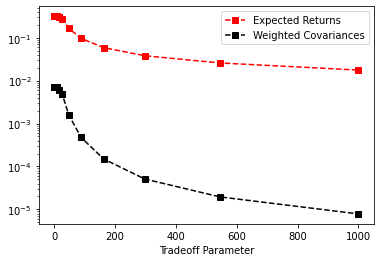

In [112]:
plt.semilogy(lbdas, expected_returns, 'rs--', label="Expected Returns")
plt.semilogy(lbdas, weighted_covariances, 'ks--', label="Weighted Covariances")
plt.legend(loc="best")
plt.xlabel("Tradeoff Parameter")
None

Text(0.5, 0, 'Tradeoff Parameter')

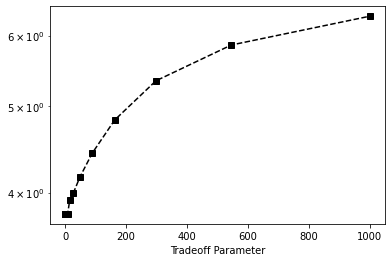

In [113]:
ratio = np.squeeze(np.array(expected_returns)) / np.sqrt(np.array(weighted_covariances))
plt.semilogy(lbdas, ratio, 'ks--')
plt.xlabel("Tradeoff Parameter")


In [114]:
selected_lbda = 100
selected_results = minimize(objective, x0, args=(selected_lbda,), constraints=constraints)
selected_x = selected_results.x
selected_series = pd.Series(selected_x, index=symbols)
selected_series

IEMG   -1.978042e-17
VWO    -4.748633e-18
SLV    -6.785735e-18
VEA    -2.457825e-17
VIXY   -4.194486e-18
            ...     
JDST    1.714823e-18
KRE     1.110546e-17
XLRE   -5.076535e-18
SOXS    1.176416e-17
TLT     6.592075e-17
Length: 99, dtype: float64

In [118]:
filtered_selected_series = selected_series[selected_series > 0.01]
filtered_selected_series = filtered_selected_series / filtered_selected_series.sum(axis=0)
filtered_selected_series

GLD    0.099400
IYR    0.160316
DIA    0.142389
QQQ    0.173048
VXX    0.057685
LQD    0.367161
dtype: float64

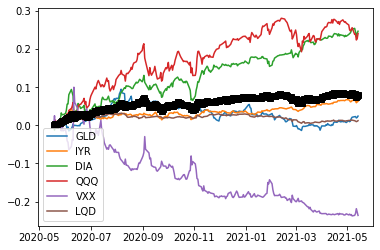

In [119]:
historic_performance = filtered_normalized_prices[filtered_selected_series.index]
aggregated_historic_performance = historic_performance.multiply(filtered_selected_series, axis=1).sum(axis=1)
for symbol in historic_performance:
    plt.plot(historic_performance[symbol], label=symbol)
plt.plot(aggregated_historic_performance, 'ks--')
plt.legend(loc="best")

In [120]:
etf_metadata = pd.read_csv(ETF_METADATA_FILEPATH)
etf_metadata = etf_metadata.set_index("Symbol")
etf_metadata["Weights"] = filtered_selected_series
etf_metadata = etf_metadata[~etf_metadata.Weights.isna()].sort_values("Weights", ascending=False)
etf_metadata

,Name,Avg Daily Share Volume (3mo),AUM,Weights
Symbol,,,,
LQD,iShares iBoxx $ Investment Grade Corporate Bon...,"15,559,789","$41,135,000.00",0.367161
QQQ,Invesco QQQ,"55,311,926","$155,519,000.00",0.173048
IYR,iShares U.S. Real Estate ETF,"7,800,508","$5,243,050.00",0.160316
DIA,SPDR Dow Jones Industrial Average ETF,"4,470,769","$30,740,800.00",0.142389
GLD,SPDR Gold Trust,"8,904,771","$60,654,200.00",0.099400
VXX,iPath Series B S&P 500 VIX Short-Term Futures ETN,"18,591,064","$1,246,790.00",0.057685


Notes
    LQD: Investment grade corporate bonds
    QQQ: Primarily tracks the NASDAQ for large-cap growth.
    IYR: iShares though blackrock, which tracks real estate
    DIA: Dow Jones Industrial average through SPDR
    GLD: ETF backed by gold offered by SPDR
    VXX: Volitility ETF based on the S&P 500. Offers a hedge and filters the swings of DIA. 
    